In [12]:
import random
from topology import Topology
from individual import Individual
import pandas as pd
import numpy as np
import itertools as it

In [13]:
class Algorithm(list):
    def __init__(
        self,
        size: int = 100,
        mutation_chance: float = 0.1,
        step_number: int = 10   
    ):
        self.size = size
        self.population: list[Individual] = []
        self.topology: Topology = []
        self.mutation_chance: float = mutation_chance
        self.step_number = step_number
    
    def read_topology(self, path):
        self.topology = Topology()
        self.topology.read_topology(path)
        return self.topology
    
    def set_bound(self, start, stop):
        self.topology.set_bound(start, stop)
        self.start = start
        self.stop = stop
        
        return self.topology
    
    def repair_bound(self):
        for individual in self.population:
            individual.direct_mutation(self.start,self.stop)
            
        return self.population
    
    def init_population(self):
        '''
        Генерация начальной популяции
        '''
        for i in range(self.size):
            individual = Individual(list(range(1, len(self.topology.matric) + 1))) # представлены все вершины
            individual.order = i + 1
            random.shuffle(individual)
            self.population.append(individual)
        return self.population
    
    def duplicate(self):
        duplicates = []
        for item in self:
            if self.count(item) > 1 and item not in duplicates:
                duplicates.append(item)


    def min_func(self, individual: Individual):
        roads = self.pairwise(individual)
        lengths = [self.topology.matric.at[a,b] for a,b in roads]
        #individual.way = sum(lengths)
        return sum(lengths)
    
    
    def pairwise(self, iterable):
        a, b = it.tee(iterable)
        next(b, None)
        return zip(a, b)
    
    def estimate(self):
        for individual in self:
            individual.estimate = 1 / (1 + self.min_func(individual))
        return self.population
    
    def __all_estimate(self):
        return sum([individual.estimate for individual in self])

    def wheel(self, population: list[Individual]):
        full_estimate = self.__all_estimate()
        for individual in population:
            individual.percent = (individual.estimate / full_estimate) * 100
        
        
        new_population = random.choices(
            population, 
            weights=[individual.percent for individual in population],
            k=len(population)
        )
        
        return new_population        



Generation 0 - Best genome: [26, 29, 4, 22, 0, 1, 19, 10, 16, 6, 24, 9, 3, 17, 8, 11, 15, 5, 25, 28, 18, 7, 21, 14, 13, 20, 12, 2, 27, 23], Score: 997
Generation 1 - Best genome: [18, 29, 4, 20, 11, 3, 19, 10, 16, 21, 24, 6, 3, 10, 28, 16, 6, 5, 25, 28, 18, 18, 21, 27, 6, 16, 27, 2, 29, 20], Score: 937
Generation 2 - Best genome: [11, 12, 7, 21, 21, 24, 9, 4, 18, 20, 24, 9, 29, 21, 26, 13, 9, 5, 23, 29, 27, 7, 21, 21, 8, 20, 12, 9, 12, 21], Score: 943
Generation 3 - Best genome: [11, 12, 7, 21, 21, 24, 20, 4, 18, 20, 24, 9, 0, 21, 0, 13, 9, 23, 23, 29, 27, 7, 21, 21, 8, 20, 25, 6, 5, 9], Score: 856
Generation 4 - Best genome: [16, 8, 8, 18, 2, 25, 19, 10, 16, 17, 25, 28, 29, 21, 8, 4, 18, 27, 23, 28, 18, 7, 5, 15, 13, 20, 6, 24, 12, 9], Score: 826
Generation 5 - Best genome: [6, 28, 1, 16, 22, 26, 16, 22, 14, 6, 8, 7, 15, 13, 0, 13, 15, 23, 23, 27, 27, 7, 7, 3, 7, 20, 25, 6, 5, 9], Score: 872
Generation 6 - Best genome: [8, 8, 8, 18, 9, 25, 19, 26, 16, 18, 9, 16, 15, 24, 12, 13, 5, 3, 

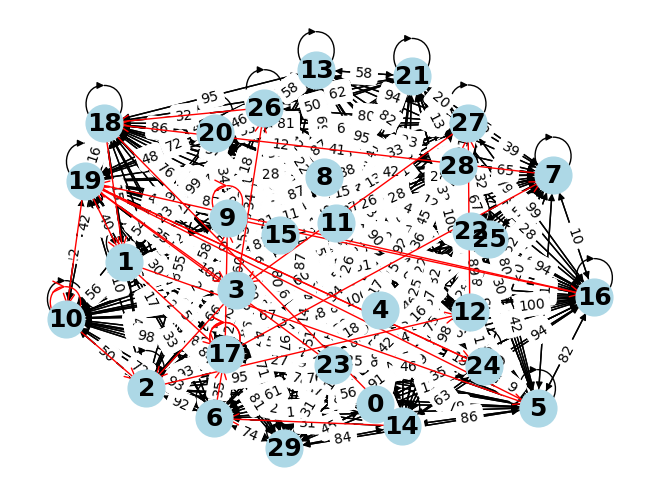

In [14]:
import random
import networkx as nx
import matplotlib.pyplot as plt

N = 30
MAX_WEIGHT = 100

graph = [[0 if i == j else random.randint(1, MAX_WEIGHT) for j in range(N)] for i in range(N)]

def init_population(pop_size, genome_length):
    population = []
    for i in range(pop_size):
        individual = list(range(genome_length))
        random.shuffle(individual)
        population.append(individual)
    return population
    #return [[random.randint(0, N-1) for _ in range(genome_length)] for _ in range(pop_size)]

def evaluate(genome):
    cost = 0
    for i in range(len(genome) - 1):
        cost += graph[genome[i]][genome[i + 1]]
    return cost

def crossover(parent1, parent2):
    idx = random.randint(1, len(parent1) - 1)
    child1 = parent1[:idx] + parent2[idx:]
    child2 = parent2[:idx] + parent1[idx:]
    return child1, child2

def mutate(genome, mutation_rate=0.5):
    for i in range(len(genome)):
        if random.random() < mutation_rate:
            genome[i] = random.randint(0, N-1)
    return genome


def draw_graph(path):
    G = nx.DiGraph()
    for i in range(len(graph)):
        for j in range(len(graph[i])):
            if graph[i][j] != 999:
                G.add_edge(i, j, weight=graph[i][j])
    
    pos = nx.spring_layout(G)
    nx.draw(G, pos, with_labels=True, node_color="lightblue", font_weight="bold", node_size=700, font_size=18)
    labels = nx.get_edge_attributes(G, "weight")
    nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)
    
    if path:
        edges = [(path[i], path[i + 1]) for i in range(len(path) - 1)]
        nx.draw_networkx_edges(G, pos, edgelist=edges, edge_color="r", arrowstyle="->", arrowsize=20)

    plt.show()

def genetic_algorithm():
    pop_size = 50
    generations = 2500
    genome_length = 30

    population = init_population(pop_size, genome_length)

    for generation in range(generations):
        scored_population = [(genome, evaluate(genome)) for genome in population]
        scored_population.sort(key=lambda x: x[1])

        selected_population = [genome for genome, _ in scored_population[:10]]

        new_population = []
        while len(new_population) < pop_size:
            parent1 = random.choice(selected_population)
            parent2 = random.choice(selected_population)
            child1, child2 = crossover(parent1, parent2)
            new_population += [child1, child2]

        new_population = [mutate(genome, mutation_rate=0.3) for genome in new_population]

        population = new_population

        best_genome, best_score = scored_population[0]
        print(f"Generation {generation} - Best genome: {best_genome}, Score: {best_score}")
    draw_graph(best_genome)

if __name__ == "__main__":
    genetic_algorithm()


Generation 0 - Best genome: [10, 23, 22, 28, 4, 15, 12, 26, 0, 1, 6, 21, 3, 13, 11, 25, 27, 7, 5, 29, 14, 24, 18, 8, 19, 17, 16, 9, 20, 2], Score: 992
Generation 1 - Best genome: [17, 22, 27, 16, 4, 15, 12, 26, 0, 1, 6, 21, 3, 13, 11, 25, 27, 7, 5, 29, 14, 24, 18, 8, 19, 17, 16, 9, 20, 2], Score: 990
Generation 2 - Best genome: [17, 2, 28, 6, 5, 10, 7, 12, 16, 11, 26, 1, 27, 23, 15, 0, 3, 8, 5, 29, 14, 24, 18, 8, 19, 17, 16, 9, 20, 2], Score: 947
Generation 3 - Best genome: [17, 2, 28, 0, 3, 16, 2, 21, 7, 9, 20, 17, 13, 27, 11, 25, 27, 7, 5, 29, 14, 24, 18, 8, 19, 17, 16, 9, 20, 2], Score: 849
Generation 4 - Best genome: [10, 23, 22, 0, 3, 16, 27, 21, 7, 9, 20, 17, 13, 2, 5, 28, 15, 24, 4, 25, 12, 28, 26, 18, 21, 6, 8, 17, 10, 20], Score: 792
Generation 5 - Best genome: [17, 2, 25, 28, 17, 13, 2, 21, 7, 20, 20, 17, 13, 2, 11, 25, 27, 7, 5, 29, 14, 24, 18, 8, 19, 17, 16, 9, 9, 2], Score: 740
Generation 6 - Best genome: [17, 2, 25, 28, 17, 13, 2, 21, 7, 20, 20, 17, 13, 2, 11, 25, 27, 24,

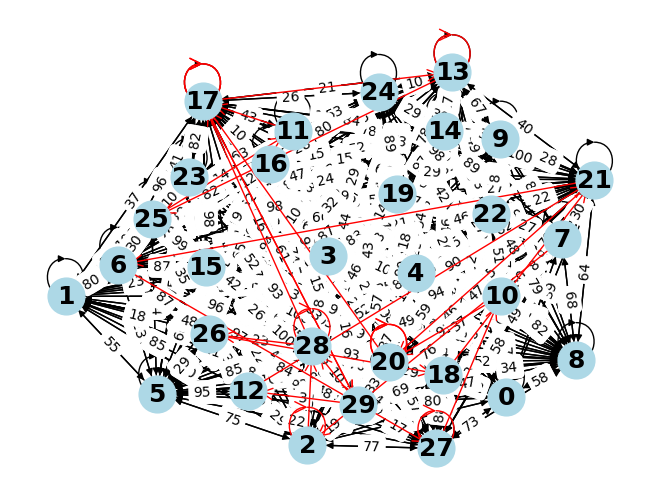

In [15]:
import random
import networkx as nx
import matplotlib.pyplot as plt

N = 30
MAX_WEIGHT = 100

graph = [[0 if i == j else random.randint(1, MAX_WEIGHT) for j in range(N)] for i in range(N)]

def init_population(pop_size, genome_length):
    population = []
    for i in range(pop_size):
        individual = list(range(genome_length))
        random.shuffle(individual)
        population.append(individual)
    return population
    #return [[random.randint(0, N-1) for _ in range(genome_length)] for _ in range(pop_size)]

def evaluate(genome):
    cost = 0
    for i in range(len(genome) - 1):
        cost += graph[genome[i]][genome[i + 1]]
    return cost

def crossover(parent1, parent2):
    idx = random.randint(1, len(parent1) - 1)
    child1 = parent1[:idx] + parent2[idx:]
    child2 = parent2[:idx] + parent1[idx:]
    return child1, child2

def mutate(genome, mutation_rate=0.2):
    if random.random() < mutation_rate:
        i, j = random.sample(range(len(genome)), 2)
        genome[i], genome[j] = genome[j], genome[i]
    return genome


def draw_graph(path):
    G = nx.DiGraph()
    for i in range(len(graph)):
        for j in range(len(graph[i])):
            if graph[i][j] != 999:
                G.add_edge(i, j, weight=graph[i][j])
    
    pos = nx.spring_layout(G)
    nx.draw(G, pos, with_labels=True, node_color="lightblue", font_weight="bold", node_size=700, font_size=18)
    labels = nx.get_edge_attributes(G, "weight")
    nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)
    
    if path:
        edges = [(path[i], path[i + 1]) for i in range(len(path) - 1)]
        nx.draw_networkx_edges(G, pos, edgelist=edges, edge_color="r", arrowstyle="->", arrowsize=20)

    plt.show()

def genetic_algorithm():
    pop_size = 50
    generations = 2500
    genome_length = 30
    elite_size = 10  # количество элитных особей
    
    population = init_population(pop_size, genome_length)

    for generation in range(generations):
        scored_population = [(genome, evaluate(genome)) for genome in population]
        scored_population.sort(key=lambda x: x[1])

        elite_population = [genome for genome, _ in scored_population[:elite_size]]

        new_population = []
        while len(new_population) < pop_size - elite_size:
            parent1 = random.choice(elite_population)
            parent2 = random.choice(elite_population)
            child1, child2 = crossover(parent1, parent2)
            new_population += [child1, child2]
        
        new_population = [mutate(genome, mutation_rate=0.2) for genome in new_population]

        population = elite_population + new_population[:pop_size - elite_size]

        best_genome, best_score = scored_population[0]
        print(f"Generation {generation} - Best genome: {best_genome}, Score: {best_score}")
    draw_graph(best_genome)

if __name__ == "__main__":
    genetic_algorithm()


# Без скрещивания

Generation 0 - Best genome: [4, 17, 22, 5, 15, 27, 28, 20, 21, 6, 25, 10, 19, 18, 9, 11, 12, 13, 26, 2, 8, 0, 29, 24, 14, 7, 16, 1, 3, 23], Score: 720
Generation 1 - Best genome: [4, 17, 22, 5, 15, 27, 28, 20, 21, 6, 25, 10, 19, 18, 9, 11, 12, 13, 26, 2, 8, 0, 29, 24, 14, 7, 16, 1, 3, 23], Score: 726
Generation 2 - Best genome: [4, 17, 10, 5, 15, 27, 28, 20, 21, 6, 25, 22, 19, 18, 9, 11, 12, 13, 26, 2, 8, 0, 29, 24, 14, 7, 16, 1, 3, 23], Score: 726
Generation 3 - Best genome: [4, 12, 14, 15, 21, 25, 0, 18, 17, 13, 2, 16, 10, 28, 26, 24, 22, 6, 23, 3, 19, 8, 7, 29, 1, 5, 9, 11, 20, 27], Score: 731
Generation 4 - Best genome: [4, 12, 14, 15, 21, 25, 0, 18, 17, 13, 2, 16, 10, 28, 26, 24, 22, 6, 23, 3, 19, 8, 7, 29, 1, 5, 9, 11, 20, 27], Score: 731
Generation 5 - Best genome: [22, 0, 18, 19, 9, 15, 8, 7, 29, 23, 27, 12, 1, 6, 17, 24, 20, 25, 16, 4, 26, 3, 28, 2, 10, 13, 14, 21, 11, 5], Score: 724
Generation 6 - Best genome: [18, 12, 14, 15, 10, 25, 0, 4, 28, 13, 2, 16, 26, 1, 21, 24, 22, 6

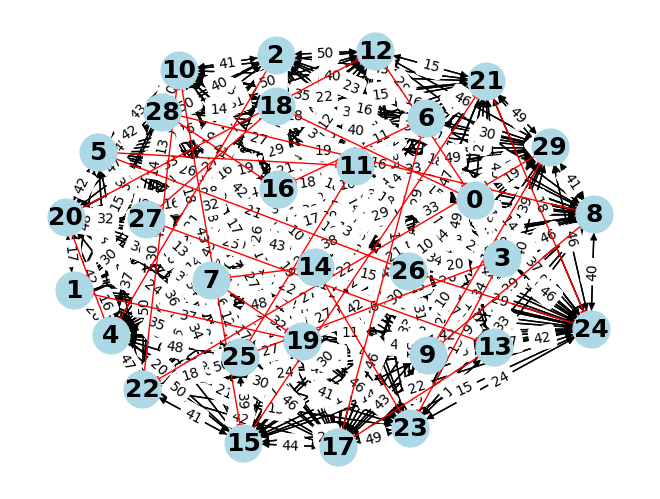

In [9]:
import random
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd

N = 30
MAX_WEIGHT = 100

#graph = [[0 if i == j else random.randint(1, MAX_WEIGHT) for j in range(N)] for i in range(N)]
df = pd.read_csv('test_matric.csv', delimiter=';', index_col=0)
df.index = pd.RangeIndex(start=0, stop=len(df), step=1)
graph = df.values.tolist()

def init_population(pop_size, genome_length):
    population = []
    for i in range(pop_size):
        individual = list(range(genome_length))
        random.shuffle(individual)
        population.append(individual)
    return population

def evaluate(genome):
    cost = 0
    for i in range(len(genome) - 1):
        cost += graph[genome[i]][genome[i + 1]]
    return cost

def mutate(genome, mutation_rate=0.2):
    if random.random() < mutation_rate:
        i, j = random.sample(range(len(genome)), 2)
        genome[i], genome[j] = genome[j], genome[i]
    return genome

def draw_graph(path):
    G = nx.DiGraph()
    for i in range(len(graph)):
        for j in range(len(graph[i])):
            if graph[i][j] != 0:
                G.add_edge(i, j, weight=graph[i][j])

    pos = nx.spring_layout(G)
    nx.draw(G, pos, with_labels=True, node_color="lightblue", font_weight="bold", node_size=700, font_size=18)
    labels = nx.get_edge_attributes(G, "weight")
    nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)
    
    if path:
        edges = [(path[i], path[i + 1]) for i in range(len(path) - 1)]
        nx.draw_networkx_edges(G, pos, edgelist=edges, edge_color="r", arrows=True)

    plt.show()

def genetic_algorithm():
    pop_size = 50
    generations = 2500
    genome_length = 30
    elite_size = 10  # количество элитных особей

    population = init_population(pop_size, genome_length)

    for generation in range(generations):
        scored_population = [(genome, evaluate(genome)) for genome in population]
        scored_population.sort(key=lambda x: x[1])

        elite_population = [genome for genome, _ in scored_population[:elite_size]]

        new_population = [mutate(genome, mutation_rate=0.2) for genome in population]
        
        population = elite_population + new_population[:pop_size - elite_size]

        best_genome, best_score = scored_population[0]
        print(f"Generation {generation} - Best genome: {best_genome}, Score: {best_score}")
    
    draw_graph(best_genome)

if __name__ == "__main__":
    genetic_algorithm()


In [7]:
N = 30
MAX_WEIGHT = 100

graph = [[0 if i == j else random.randint(1, MAX_WEIGHT) for j in range(N)] for i in range(N)]

print(graph)

[[0, 13, 93, 94, 42, 32, 32, 47, 25, 81, 27, 4, 45, 10, 93, 23, 90, 23, 3, 73, 72, 33, 4, 6, 50, 10, 99, 11, 13, 91], [1, 0, 14, 20, 99, 65, 36, 84, 15, 94, 95, 94, 24, 37, 18, 93, 70, 87, 12, 98, 21, 97, 27, 89, 15, 15, 4, 43, 51, 59], [11, 78, 0, 92, 19, 29, 63, 26, 87, 56, 78, 40, 89, 47, 5, 74, 64, 31, 49, 34, 30, 29, 5, 64, 17, 86, 58, 27, 48, 70], [78, 19, 76, 0, 47, 30, 32, 96, 90, 79, 100, 57, 14, 39, 63, 41, 22, 7, 87, 26, 21, 69, 35, 81, 61, 49, 24, 29, 56, 85], [6, 30, 44, 51, 0, 24, 96, 19, 15, 91, 2, 86, 29, 19, 38, 48, 60, 87, 16, 41, 74, 20, 31, 2, 1, 54, 44, 80, 53, 84], [93, 14, 49, 42, 32, 0, 1, 6, 41, 15, 4, 16, 17, 95, 85, 87, 78, 14, 77, 31, 5, 84, 70, 10, 19, 29, 85, 8, 78, 98], [8, 61, 65, 28, 13, 95, 0, 21, 23, 7, 67, 17, 20, 69, 33, 60, 52, 33, 46, 3, 58, 43, 80, 80, 50, 37, 38, 97, 46, 62], [96, 88, 24, 15, 33, 59, 35, 0, 22, 82, 85, 27, 35, 85, 32, 100, 85, 29, 88, 22, 72, 53, 37, 80, 81, 100, 12, 87, 52, 93], [10, 27, 39, 59, 63, 100, 32, 54, 0, 63, 68, 57, 

# Генерация графа

In [13]:
from topology import Topology

t = Topology()
t.generate_topology(path='my.csv', size=(30, 30), bandwidth_range=(10, 100))

,1,2,3,4,5,6,7,8,9,10,...,21,22,23,24,25,26,27,28,29,30
1,0,22,51,41,41,56,34,90,36,13,...,15,59,19,20,22,100,10,23,29,74
2,22,0,45,93,24,33,46,27,79,96,...,20,87,28,38,72,35,96,65,87,49
3,51,45,0,98,56,14,83,73,40,58,...,79,87,28,85,56,39,41,99,88,66
4,41,93,98,0,23,48,72,50,31,16,...,65,94,15,39,53,60,33,28,24,100
5,41,24,56,23,0,11,95,38,28,47,...,63,53,89,62,93,23,58,51,41,10
6,56,33,14,48,11,0,15,50,24,13,...,79,19,28,38,94,17,87,17,70,74
7,34,46,83,72,95,15,0,37,22,30,...,55,12,67,52,89,89,59,46,47,55
8,90,27,73,50,38,50,37,0,71,97,...,94,41,94,38,97,31,81,62,46,89
9,36,79,40,31,28,24,22,71,0,90,...,72,77,66,84,53,54,34,74,87,54
10,13,96,58,16,47,13,30,97,90,0,...,28,55,45,68,84,51,50,84,15,13


# Кажись лучший выбор

In [21]:
import random
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

N = 30
MAX_WEIGHT = 100

#graph = [[0 if i == j else random.randint(1, MAX_WEIGHT) for j in range(N)] for i in range(N)]
df = pd.read_csv('test_matric.csv', delimiter=';', index_col=0)
df.index = pd.RangeIndex(start=0, stop=len(df), step=1)
graph = df.values.tolist()

def init_population(pop_size, genome_length, start_vertex, end_vertex):
    population = []
    for i in range(pop_size):
        individual = list(range(genome_length))
        individual.remove(start_vertex)
        individual.remove(end_vertex)
        random.shuffle(individual)
        individual = [start_vertex] + individual + [end_vertex]
        population.append(individual)
    return population

def evaluate(genome):
    cost = 0
    for i in range(len(genome) - 1):
        cost += graph[genome[i]][genome[i + 1]]
    return cost

def crossover(parent1, parent2):
    idx = random.randint(1, len(parent1) - 1)
    child1 = parent1[:idx] + parent2[idx:]
    child2 = parent2[:idx] + parent1[idx:]
    return child1, child2

def mutate(genome, mutation_rate=0.2):
    for i in range(1, len(genome) - 1):  # Исключим начальную и конечную вершины
        if random.random() < mutation_rate:
            j = random.randint(1, len(genome) - 2)
            genome[i], genome[j] = genome[j], genome[i]
    return genome

def draw_graph(path):
    G = nx.DiGraph()
    for i in range(len(graph)):
        for j in range(len(graph[i])):
            if graph[i][j] != 999:
                G.add_edge(i, j, weight=graph[i][j])
    
    pos = nx.spring_layout(G)
    nx.draw(G, pos, with_labels=True, node_color="lightblue", font_weight="bold", node_size=700, font_size=18)
    labels = nx.get_edge_attributes(G, "weight")
    nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)
    
    if path:
        edges = [(path[i], path[i + 1]) for i in range(len(path) - 1)]
        nx.draw_networkx_edges(G, pos, edgelist=edges, edge_color="r", arrowstyle="->", arrowsize=20)

    plt.show()

def genetic_algorithm(
        start_vertex=0, 
        end_vertex=N-1,
        pop_size=50,
        generations=2500,
        elite_size=10,
        genome_length=30,
        mutation_rate=0.2,
        info=True):
    
    population = init_population(pop_size, genome_length, start_vertex, end_vertex)

    for generation in range(generations):
        scored_population = [(genome, evaluate(genome)) for genome in population]
        scored_population.sort(key=lambda x: x[1])

        elite_population = [genome for genome, _ in scored_population[:elite_size]]

        new_population = []
        while len(new_population) < pop_size - elite_size:
            parent1 = random.choice(elite_population)
            parent2 = random.choice(elite_population)
            child1, child2 = crossover(parent1, parent2)
            new_population += [child1, child2]
        
        new_population = [mutate(genome, mutation_rate=mutation_rate) for genome in new_population]

        population = elite_population + new_population[:pop_size - elite_size]

        best_genome, best_score = scored_population[0]
        mean = np.mean([individual[1] for individual in scored_population])
        if info:
            print(f"Generation {generation} - Best genome: {best_genome}, Score: {best_score}, Mean: {mean}")

    return best_genome, best_score


random.seed(7)
start_vertex = 1
end_vertex = 25
best_genome, best_score = genetic_algorithm(start_vertex, end_vertex)


Generation 0 - Best genome: [1, 8, 4, 15, 21, 23, 11, 10, 20, 7, 3, 0, 19, 29, 27, 12, 16, 17, 18, 24, 13, 28, 22, 14, 5, 9, 6, 26, 2, 25], Score: 722, Mean: 861.78
Generation 1 - Best genome: [1, 0, 17, 16, 18, 21, 11, 6, 26, 3, 4, 8, 13, 18, 21, 24, 5, 10, 7, 2, 16, 19, 20, 6, 28, 15, 0, 12, 22, 25], Score: 669, Mean: 804.66
Generation 2 - Best genome: [1, 12, 8, 6, 28, 0, 4, 24, 20, 16, 16, 20, 13, 18, 15, 24, 28, 6, 7, 2, 9, 4, 8, 10, 12, 21, 0, 5, 22, 25], Score: 616, Mean: 766.58
Generation 3 - Best genome: [1, 6, 5, 8, 24, 6, 5, 21, 20, 24, 21, 23, 7, 18, 15, 24, 28, 10, 7, 2, 9, 22, 20, 0, 28, 3, 0, 12, 22, 25], Score: 605, Mean: 753.28
Generation 4 - Best genome: [1, 12, 8, 6, 20, 0, 4, 24, 20, 16, 16, 28, 13, 15, 18, 24, 28, 6, 7, 2, 9, 4, 8, 10, 0, 26, 5, 29, 10, 25], Score: 577, Mean: 720.88
Generation 5 - Best genome: [1, 12, 15, 6, 15, 0, 18, 24, 4, 16, 16, 24, 20, 20, 2, 13, 12, 6, 7, 6, 9, 4, 8, 28, 28, 8, 22, 12, 22, 25], Score: 570, Mean: 698.0
Generation 6 - Best gen

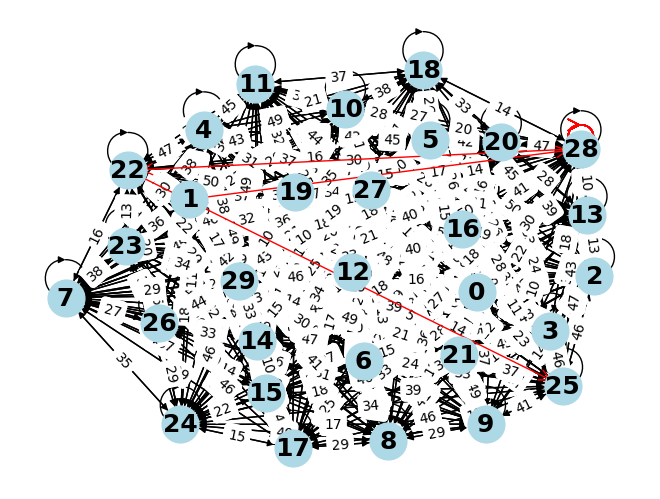

In [18]:
draw_graph(best_genome)

In [ ]:
genetic_algorithm(start_vertex, end_vertex)

In [22]:
random.seed(7)
start_vertex = 1
end_vertex = 25

pop_data = []
generations_data = []
elite_data = []
mutation_data = []

pop_sizes = [5, 10, 30, 50, 100]
generations_count = [100, 300, 500, 1000, 2000]
elite_count = [3, 5, 7, 15, 30]
mutation_count = [0.05, 0.1, 0.2, 0.5, 0.9]

for pop_size in pop_sizes:
    random.seed(7)
    best_genome, best_score = genetic_algorithm(start_vertex, end_vertex, pop_size=pop_size, info=False)
    pop_data.append(best_score)

for generations in generations_count:
    random.seed(7)
    best_genome, best_score = genetic_algorithm(start_vertex, end_vertex, generations=generations, info=False)
    generations_data.append(best_score)

for elite_size in elite_count:
    random.seed(7)
    best_genome, best_score = genetic_algorithm(start_vertex, end_vertex, elite_size=elite_size, info=False)
    elite_data.append(best_score)

for mutation_rate in mutation_count:
    random.seed(7)
    best_genome, best_score = genetic_algorithm(start_vertex, end_vertex, mutation_rate=mutation_rate, info=False)
    mutation_data.append(best_score)

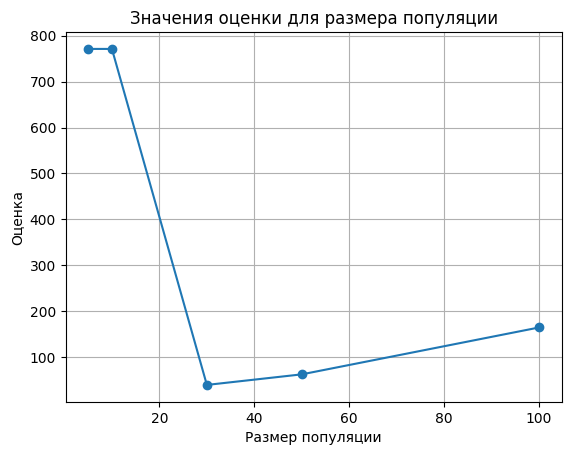

In [24]:
plt.plot(pop_sizes, pop_data, marker='o')
plt.title('Значения оценки для размера популяции')
plt.xlabel('Размер популяции')
plt.ylabel('Оценка')
plt.grid(True)
plt.show()

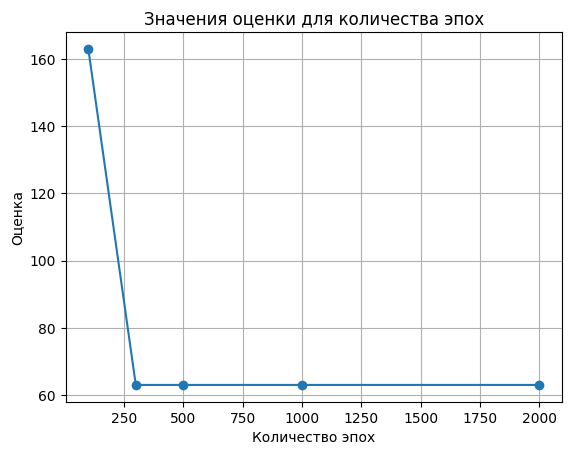

In [28]:
plt.plot(generations_count, generations_data, marker='o')
plt.title('Значения оценки для количества эпох')
plt.xlabel('Количество эпох')
plt.ylabel('Оценка')
plt.grid(True)
plt.show()

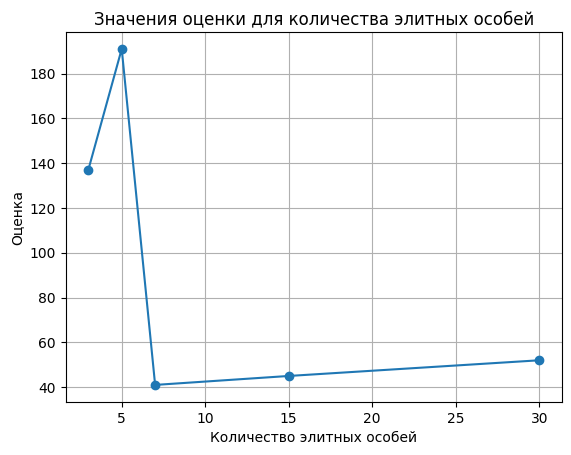

In [26]:
plt.plot(elite_count, elite_data, marker='o')
plt.title('Значения оценки для количества элитных особей')
plt.xlabel('Количество элитных особей')
plt.ylabel('Оценка')
plt.grid(True)
plt.show()

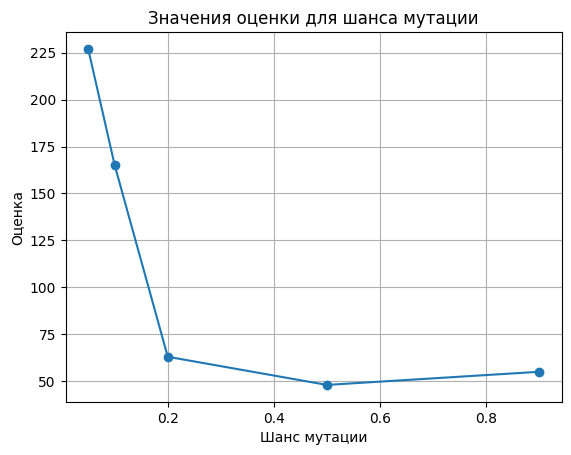

In [27]:
plt.plot(mutation_count, mutation_data, marker='o')
plt.title('Значения оценки для шанса мутации')
plt.xlabel('Шанс мутации')
plt.ylabel('Оценка')
plt.grid(True)
plt.show()